# Library Imports

In [1]:
import keras.losses
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split as tts
from matplotlib import pyplot as pp
# you can add more imports here as needed.

# Seed
seed = 1234
np.random.seed(seed)

# Loading the Data Set
The below code loads the data set we'll use for this assignment. The data self itself consists of images of playing cards that vary in appearance. The goal of the program is to be able to accurately classify the image based on what playing card is shown in the image using the various neural networks we'll build.

To go more into detail about the data set, it contains various images for all 52 cards in a standard deck of cards. It also contains images for the Joker card present in most playing card decks, making for 53 total factors to consider. Since the only predictor will be the image of the card, I will not provide any graphs since raw image data may not make for the best graph data.

In [34]:
# Load the data set
CardData = pd.read_csv("cards.csv")

# Rename label column
CardData['card'] = CardData.labels
CardData = CardData.drop(columns=["labels"])

# Remove row with path going to "output.jpg"
CardData = CardData.loc[CardData["filepaths"] != "train/ace of clubs/output"]

# Build predictor column
x = []
for path in CardData["filepaths"]:
    # read image
    image = tf.keras.utils.load_img(path, color_mode="rgb", target_size=(200, 200))
    image_arr = tf.keras.preprocessing.image.img_to_array(image)
    x.append(image_arr)

# Convert predictor column x to numpy array
x = np.array(x)
print("x dim:", x.shape)

x dim: (8154, 200, 200, 3)


# Cleaning the Data Set
We'll continue by performing some data cleaning, by getting rid of unnecessary columns, changing column name(s) to more suitable names, and normalizing the image data for use in our neural networks.

In [35]:
# Drop unneeded columns
CardData = CardData.drop(columns=["filepaths", "class index", "card type", "data set"])

# Factor card column
CardData.card = CardData.card.astype('category').cat.codes

# Normalize image data
x /= 255.0

# Set target column y
num_classes = 53
y = CardData.card
y = tf.keras.utils.to_categorical(y, num_classes)
print("y dim:", y.shape)

y dim: (8154, 53)


# Train/Test Split
Now, we'll split the data to train/test in preparation for our neural networks. We'll give it a pre-defined seed so that we'll always get the same results. We'll really only be using the image data to predict what card it is, so both the x and y will be one column.

In [36]:
# Split the data into Train/Test
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=seed)

# Output Dimensions
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

6523 train samples
1631 test samples


# Model Training & Prediction
Now, we can finally start performing machine learning on the data by building our neural networks! We'll utilize three variations: Sequential, CNN, and RNN. For accreditation, Justin worked on both the Sequential and CNN portions, and Benji worked on the RRN portion.

## Sequential
The first model we'll experiment with is a regular, generic Sequential Neural Network. We can expect this model to perform poorly on the data since we won't be utilizing any CNN convolutions, which is fairly vital for image data.

In [37]:
# Declare Sequential specifications
batch_size_seq = 32
epochs_seq = 10

# Create model
seq = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(200, 200, 3)),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

# Print model summary
print(seq.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 120000)            0         
                                                                 
 dense_29 (Dense)            (None, 16)                1920016   
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_30 (Dense)            (None, 32)                544       
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 64)                2112      
                                                                 
 dropout_19 (Dropout)        (None, 64)               

In [39]:
# Predict on the model
seq.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history_seq = seq.fit(x_train, y_train, batch_size=batch_size_seq, epochs=epochs_seq, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
204/204 [==============================] - 5s 22ms/step - loss: 5.2393 - accuracy: 0.0225 - val_loss: 3.9705 - val_accuracy: 0.0208
Epoch 2/10
204/204 [==============================] - 4s 20ms/step - loss: 3.9678 - accuracy: 0.0244 - val_loss: 3.9712 - val_accuracy: 0.0208
Epoch 3/10
204/204 [==============================] - 4s 21ms/step - loss: 3.9666 - accuracy: 0.0231 - val_loss: 3.9716 - val_accuracy: 0.0208
Epoch 4/10
204/204 [==============================] - 4s 21ms/step - loss: 3.9656 - accuracy: 0.0241 - val_loss: 3.9714 - val_accuracy: 0.0208
Epoch 5/10
204/204 [==============================] - 4s 21ms/step - loss: 3.9653 - accuracy: 0.0238 - val_loss: 3.9713 - val_accuracy: 0.0208
Epoch 6/10
204/204 [==============================] - 4s 20ms/step - loss: 3.9640 - accuracy: 0.0238 - val_loss: 3.9701 - val_accuracy: 0.0208
Epoch 7/10
204/204 [==============================] - 4s 20ms/step - loss: 3.9653 - accuracy: 0.0228 - val_loss: 3.9689 - val_accuracy: 0.0208

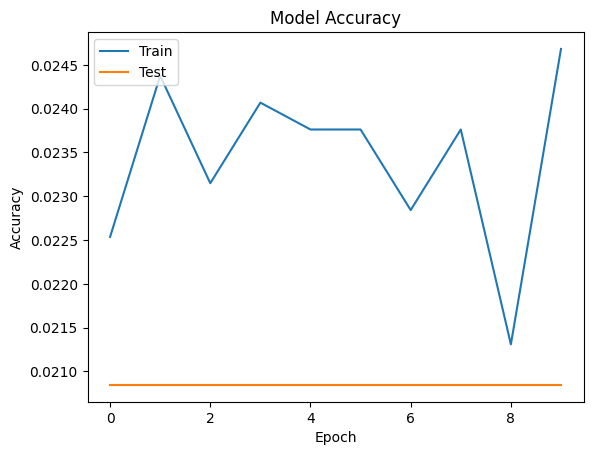

In [40]:
# Plot train/test accuracy values
pp.plot(history_seq.history["accuracy"])
pp.plot(history_seq.history["val_accuracy"])
pp.title("Model Accuracy")
pp.ylabel("Accuracy")
pp.xlabel("Epoch")
pp.legend(["Train", "Test"], loc="upper left")
pp.show()

As expected, the model did not perform well at all. It achieved a low accuracy of roughly 2% accuracy on both splits of data. Of course, this can be attributed to the fact that we're using a neural network not designed well for image data. Which serves as the perfect segue into the next model...

## CNN
The next model is the Convolutional Neural Network, which is known to work extremely well with image data. Since we've represented the image data in a matrix, we add a 2D convolutional layer to our model which will help the model learn patterns of the image in small windows. This will be especially useful for learning patterns in the card data, as the card image's patterns exist mainly in the corners of the image, and sometimes consistently in the center.

In [42]:
# Declare CNN specifications
batch_size_cnn = 64
epochs_cnn = 10

# Create model
cnn = tf.keras.models.Sequential(
    [
        tf.keras.Input(shape=(200, 200, 3)),
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ]
)

# Print model summary
print(cnn.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 99, 99, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 23, 23, 64)     

In [44]:
# Predict on the model
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_cnn = cnn.fit(x_train, y_train, batch_size=batch_size_cnn, epochs=epochs_cnn, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
102/102 [==============================] - 98s 942ms/step - loss: 3.1955 - accuracy: 0.1922 - val_loss: 2.4191 - val_accuracy: 0.3397
Epoch 2/10
102/102 [==============================] - 95s 933ms/step - loss: 2.0781 - accuracy: 0.4297 - val_loss: 1.9180 - val_accuracy: 0.4991
Epoch 3/10
102/102 [==============================] - 95s 928ms/step - loss: 1.5808 - accuracy: 0.5796 - val_loss: 1.6860 - val_accuracy: 0.5757
Epoch 4/10
102/102 [==============================] - 90s 885ms/step - loss: 1.2116 - accuracy: 0.6728 - val_loss: 1.5814 - val_accuracy: 0.6260
Epoch 5/10
102/102 [==============================] - 89s 876ms/step - loss: 0.9232 - accuracy: 0.7402 - val_loss: 1.6303 - val_accuracy: 0.6419
Epoch 6/10
102/102 [==============================] - 90s 884ms/step - loss: 0.6602 - accuracy: 0.8134 - val_loss: 1.6504 - val_accuracy: 0.6585
Epoch 7/10
102/102 [==============================] - 91s 887ms/step - loss: 0.4897 - accuracy: 0.8571 - val_loss: 1.8714 - val_ac

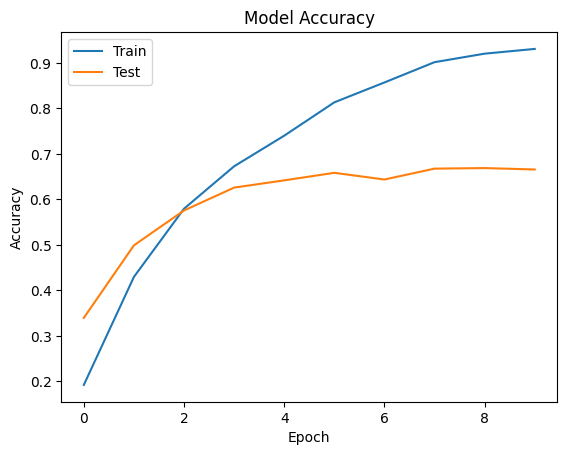

In [45]:
# Plot train/test accuracy values
pp.plot(history_cnn.history["accuracy"])
pp.plot(history_cnn.history["val_accuracy"])
pp.title("Model Accuracy")
pp.ylabel("Accuracy")
pp.xlabel("Epoch")
pp.legend(["Train", "Test"], loc="upper left")
pp.show()

As expected, the model performed significantly better, achieving a 90~% accuracy on the training data and a 65~% accuracy on the test data. While the improved results are expected, the model is definitely not perfect as the carry-over of accuracy from the train data to the test data has a considerable difference, with about a 25% difference in accuracy between the train & test data.

This is likely due to overfitting, which CNN is known to be susceptible to. This is largely because of the model I created being complex, which I'm sure could use improvements. However, out of all the setups of layers that I'd tried, this setup performed the best.

## Pretrained Model & Transfer Learning
Finally, we'll try out a pretrained model on the data, to see how it performs. To complete this portion of the assignment, I'd read up on pretrained models and transfer learning through the [link we were provided](https://www.tensorflow.org/tutorials/images/transfer_learning).

In [70]:
# Declare Transfer Learning specifications
batch_size_tl = 32
epochs_tl = 10

# Create new model on top on a pretrained model
base = tf.keras.applications.VGG16(weights="imagenet", input_shape=(200, 200, 3), include_top=False)
base.trainable = False
inputs_tl = tf.keras.layers.Input(shape=(200, 200, 3))
layers_tl = base(inputs_tl, training=False)
layers_tl = tf.keras.layers.Flatten()(layers_tl)
layers_tl = tf.keras.layers.Dropout(0.25)(layers_tl)
layers_tl = tf.keras.layers.Dense(64, activation='relu')(layers_tl)
outputs_tl = tf.keras.layers.Dense(num_classes, activation='softmax')(layers_tl)
tl = tf.keras.Model(inputs_tl, outputs_tl)

In [71]:
tl.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history_tl = tl.fit(x_train, y_train, batch_size=batch_size_tl, epochs=epochs_tl, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
204/204 [==============================] - 792s 4s/step - loss: 3.1250 - accuracy: 0.2028 - val_loss: 2.2163 - val_accuracy: 0.4212
Epoch 2/10
204/204 [==============================] - 707s 3s/step - loss: 1.7255 - accuracy: 0.5453 - val_loss: 1.5746 - val_accuracy: 0.5874
Epoch 3/10
204/204 [==============================] - 698s 3s/step - loss: 1.1949 - accuracy: 0.6859 - val_loss: 1.3840 - val_accuracy: 0.6321
Epoch 4/10
204/204 [==============================] - 698s 3s/step - loss: 0.9155 - accuracy: 0.7585 - val_loss: 1.2344 - val_accuracy: 0.6714
Epoch 5/10
204/204 [==============================] - 696s 3s/step - loss: 0.7085 - accuracy: 0.8131 - val_loss: 1.1817 - val_accuracy: 0.6959
Epoch 6/10
204/204 [==============================] - 706s 3s/step - loss: 0.5542 - accuracy: 0.8603 - val_loss: 1.1518 - val_accuracy: 0.7014
Epoch 7/10
204/204 [==============================] - 695s 3s/step - loss: 0.4610 - accuracy: 0.8786 - val_loss: 1.1705 - val_accuracy: 0.6983

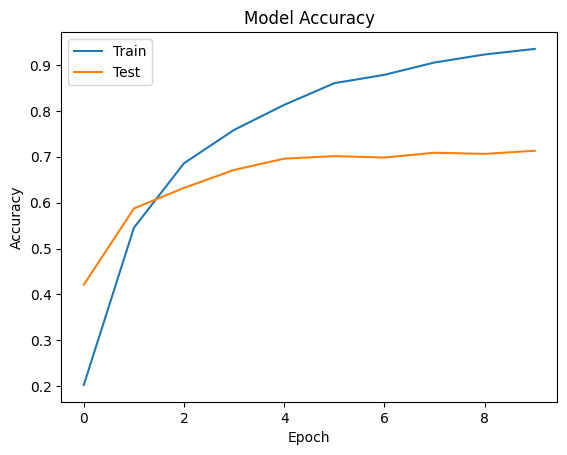

In [72]:
# Plot train/test accuracy values
pp.plot(history_tl.history["accuracy"])
pp.plot(history_tl.history["val_accuracy"])
pp.title("Model Accuracy")
pp.ylabel("Accuracy")
pp.xlabel("Epoch")
pp.legend(["Train", "Test"], loc="upper left")
pp.show()

As we can see from the results, the pretrained model performed better than the CNN model I'd designed, achieving a 90~% accuracy on the train data and most notably, a 70~% accuracy on the test data. Due to the nature of this model being pretrained on larger data sets, it makes sense that it'd perform a simpler model created by someone who's rather novice when it comes to neural networks.

The main issue I noticed with using a pretrained model is that the training time skyrocketed; each epoch took 10~ minutes to complete, meaning I left it to train for over an hour and a half.

# Analysis
To review what we've learned from this assignment, it's really clear that for image classification projects, Convolutional Neural Networks are the way to go. This is further supported not only by the results, but the fact that pretrained models gravitate towards using this approach. And based off the results, we know that using a regular, generic sequential model seems to yield rather disappointing results on image classification data sets (assuming my implementation of the model was correct).

In my tests, however, CNN does seemingly tend to overfit the model. In early tests, the model would achieve 99% accuracy on the train data, and only ~50% accuracy on the test data. The implication in this large gap in accuracy is that the model didn't do too well at generalizing the data, and only served as a near perfect model for one sample of that data (the train data). Restructuring the layering by adding convolutions and another dense layer near the end seemed to help mend this issue, and narrow the gap significantly.

For the most part, the difference between the performance of my CNN model and the pretrained model is relatively small. For that reason, I'm pretty happy with the results that I was able to get with my implementation of the CNN approach, though I'm mindful of the fact that it could definitely be improved further to better generalize the data; as evidenced by the pretrained model's results.